In [46]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import os
import string
import re
import pymorphy2
from collections import OrderedDict
from nltk.probability import FreqDist
from nltk.stem.snowball import SnowballStemmer 
from stop_words import get_stop_words
from ipywidgets import IntProgress
from IPython.display import display

Функция прогресса итерации:

In [47]:
def log_progress(sequence, every=1):
    progress = IntProgress(min=0, max=len(sequence), value=0)
    display(progress)
    
    for index, record in enumerate(sequence):
        if index % every == 0:
            progress.value = index
        yield record 

Фильтр (feature toggle) по iot категориям:

In [48]:
iot_class = True

Гиперпараметры:

In [49]:
#минимальная длина стоп слова:
min_word_length = 2

#минимальная частота слова в синтетическом словаре 
freq_min = 0.01

Читаем директорию с файлами каталога:

In [50]:
list_of_files = os.listdir('data/top_ym/')
files_num = len(list_of_files) 

Выбор необходимых атрибутов:

In [51]:
market_features = ['Категория', 'Производитель', 'Название модели']

Читаем файлы с необходимыми атрибутами в один фрейм:

In [52]:
df = pd.DataFrame()
for item in log_progress(list_of_files, every=1):      
    df_file = pd.read_csv(('data/top_ym/' + str(item)), delimiter=';', encoding='windows-1251', usecols=market_features)
    df = pd.concat([df, df_file], axis=0)

IntProgress(value=0, max=313)

Записываем фрейм в csv файл:

In [53]:
df.to_csv('data/market_dirty.csv', index=False)

Переименовываем столбцы:

In [54]:
df = df.rename(columns={'Категория': 'class_m', 'Производитель': 'ven_m', 'Название модели': 'model_m'})

Число записей:

In [55]:
dim_before = int(df.shape[0])
print('Число записей:', int(df.shape[0]))

Число записей: 3421187


Показываем пропуски в относительных долях:

In [56]:
print('Число нулей для всех признаков:', dict(round(df.isnull().sum()/len(df), 2)))

Число нулей для всех признаков: {'class_m': 0.0, 'ven_m': 0.0, 'model_m': 0.0}


Показываем пропуски в абсолютных значения:

In [57]:
print('Число нулей для всех признаков:', dict(df.isnull().sum()))

Число нулей для всех признаков: {'class_m': 0, 'ven_m': 0, 'model_m': 0}


Сброс записей с пропущенными значениями:

In [58]:
df.dropna(how='any', axis=0, inplace=True)

Удаление пунктуации из строковых атрибутов:

In [59]:
for item in list(string.punctuation): 
    df[['class_m', 'model_m']] = df[['class_m', 'model_m']].applymap(lambda x: x.replace(item, ' '))

Убираем пробелы и приводим к нижнему регистру:

In [60]:
df = df.applymap(lambda x: re.sub(' +', ' ', x) if isinstance(x, str) else x)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

Сброс дубликатов:

In [61]:
df.drop_duplicates(inplace=True, keep='first', subset=['class_m', 'ven_m', 'model_m'])

Преобразование типов:

In [62]:
df = df.astype({'class_m': 'str', 'ven_m': 'str', 'model_m': 'str'})

Выводим число нулей:

In [63]:
print('Число нулей для всех признаков:', dict(df.isnull().sum()))

Число нулей для всех признаков: {'class_m': 0, 'ven_m': 0, 'model_m': 0}


Записываем категории в filter/classes.txt:

In [64]:
with open('filter/classes.txt', 'w') as f:
    f.writelines('%s\n' % item for item in list(set(df['class_m'])))        

На основе файла составляем список исключений без sim (фильтр по iot устройствам). Записываем в except_class.txt. Читаем исключения из файла в новый список exceptions:

In [65]:
exceptions = []
with io.open('filter/except_class.txt', 'r', newline=None, encoding='utf-8') as file:
    for item in file:
        item = item.replace('\n', '') 
        exceptions.append(item)

Оставляем категории товаров, которых нет в списке исключений:

In [66]:
if iot_class is True:
    df = df[~df['class_m'].isin(exceptions)] 

Удаляем дублирующиеся слова в названии модели:

In [67]:
df['model_m'] = df['model_m'].apply(lambda x: ' '.join(OrderedDict.fromkeys(x.split())))

Удаляем производителей из названий модели:

In [68]:
for item in log_progress(list(set(df['ven_m'])), every=1):
    df['model_m'] = df['model_m'].apply(lambda x: x.replace(item, ''))

IntProgress(value=0, max=351)

Составляем список стоп слов русского словаря с фильтром по длине: 

In [69]:
stop_words_ru = [item for item in get_stop_words('russian') if len(item) > min_word_length]

Удаляем стоп слова в названии модели:

In [70]:
for stop in log_progress(stop_words_ru, every=1):
    remove_stops = (lambda x: ' '.join([item for item in x.split() if item != stop]))
    df['model_m'] = df['model_m'].apply(remove_stops)    

IntProgress(value=0, max=375)

Создаем вектор ключевых слов по названиям категорий:

In [71]:
keys = " ".join(list(set(df['class_m'])))
keys = list(set(keys.split()))
keys = [x for x in keys if len(x) > min_word_length]

Приводим слова категорий к стандартной форме:

In [72]:
morph = pymorphy2.MorphAnalyzer()
keys = [morph.parse(item)[0].normal_form for item in keys]

Выделяем основы/корни из списка - стемминг:

In [73]:
stemmer = SnowballStemmer("russian") 
keys = [stemmer.stem(item) for item in keys]

Если в слове из наименования модели присутствует 'основа' - генератор ключевого слова, то слово удаляется: 

In [74]:
for key in keys:
    remove_keys = (lambda x: ' '.join([item for item in x.split() if (key not in item)]))
    df['model_m'] = df['model_m'].apply(remove_keys)

Создаем словарь из наименований моделей:

In [75]:
text = list(' '.join(list(df['model_m'])).split())  

Оставляем только русские слова в списке:

In [76]:
text = [re.sub('[^А-Яа-я]', '', x.strip()) for x in text]
text = [x for x in text if len(x) > min_word_length]

Составляем функцию распределения слов по частоте:

In [77]:
model_dict = list(FreqDist(text).most_common(len(text)))
model_dict = [(x, y/len(text)) for (x,y) in model_dict]

Выводим СЧХ на экран:

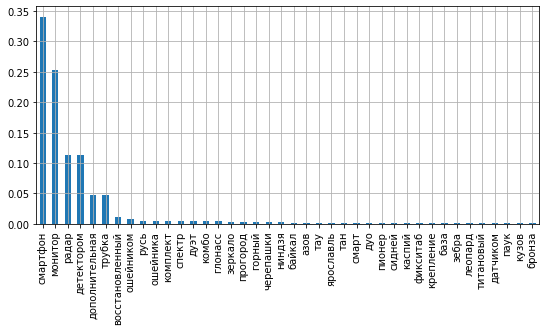

In [78]:
df_model_dict = pd.DataFrame(model_dict, columns=['Словарь', 'Частота'])
fig = df_model_dict.plot(kind='bar', x='Словарь', legend=False, figsize=(9,4), grid=True)
fig.xaxis.set_label_text("")
plt.show()

Оставляем слова в словаре с частотой более, чем freq_min:

In [79]:
model_dict = [(x,y) for (x,y) in model_dict if float(y) > freq_min]

Приводим список слов в нормальной форме:

In [80]:
model_dict = [x for (x,y) in model_dict]
model_dict = [morph.parse(item)[0].normal_form for item in model_dict]

Выделяем основы/корни из высокочастотного словаря - стемминг:

In [81]:
model_dict = [stemmer.stem(item) for item in model_dict]

Если в слове из наименования модели присутствует 'основа' - генератор, то слово удаляется: 

In [82]:
for word in model_dict:
    remove_keys = (lambda x: ' '.join([item for item in x.split() if (word not in item)]))
    df['model_m'] = df['model_m'].apply(remove_keys)

Удаляем записи с пропущенными значениями:

In [83]:
df.dropna(how='any', axis=0, inplace=True)

Статистики по распределению числа слов в наименовании модели:

In [84]:
print('Среднее число слов:', round(df['model_m'].str.split().apply(len).mean()))
print('Разброс числа слов:', round(df['model_m'].str.split().apply(len).max()-df['model_m'].str.split().apply(len).min()))

Среднее число слов: 3
Разброс числа слов: 11


Статистики по распределению числа символов в наименовании модели:

In [85]:
print('Среднее число символов:', round(df['model_m'].apply(len).mean()))
print('Разброс числа символов:', round(df['model_m'].apply(len).max()-df['model_m'].apply(len).min()))

Среднее число символов: 11
Разброс числа символов: 68


Число записей:

In [86]:
dim_after = int(df.shape[0])
print('Число записей:', int(df.shape[0]))

Число записей: 7298


Компрессия по числу записей:

In [87]:
print('Компрессия по числу записей:', round(dim_before/dim_after))

Компрессия по числу записей: 469


Описание фрейма:

In [88]:
df.describe()[:2][:]

,class_m,ven_m,model_m
count,7298,7298,7298
unique,11,351,6477


Выводим случайный сэмпл:

In [89]:
df.sample(n=5)

,class_m,ven_m,model_m
3690,телевизоры,skyline,22lt5900
3586,телевизоры,tcl,жк l65p6us
9664,планшеты,apple,ipad mini 2 128gb wi fi cellular
11944,планшеты,xiaomi,mipad 4 64gb
11617,видеорегистраторы,eplutus,с gr 92


Записываем csv в директорию:

In [90]:
df.to_csv('data/market_clean.csv', index=False)